# XGBoost Time Series Forecasting

In [91]:
import pandas as pd
from pandas import concat
from numpy import asarray
from pandas import DataFrame
import numpy as np
import joblib
import hashlib
import tensorflow as tf
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor,IsolationForest
from sklearn.feature_selection import SelectKBest,f_regression
from xgboost.sklearn import XGBRegressor,XGBClassifier
from xgboost import plot_importance, plot_tree

from sklearn.model_selection import KFold, cross_val_score, train_test_split

import pickle
import warnings
warnings.filterwarnings("ignore")

In [92]:
def selectColumns(df,colm_array):
    df_selected=df[colm_array]
    return df_selected;

# Data Load

In [93]:
time_model_df = pd.read_csv('final_data_whole.csv',index_col=0)
time_model_df = time_model_df[time_model_df.org == 'DCW']
time_model_df = time_model_df[time_model_df.dst == 'ICN']
time_model_df.head(5)


,Flight_No,org,dst,SCH_DEP_DATE,BKD_WT_sum,BKD_VOL_sum,CHG_WT_BU_sum,INHOUSE_AC_TYP,OPN_MODE,SVC_TYP,...,ORG_AIRPORT_NAME,ORG_CNTRY_NAME,ORG_REGION_NAME,DST_AIRPORT_CODE,DST_AIRPORT_NAME,DST_CNTRY_NAME,DST_REGION_NAME,org_hday_flg,dst_hday_flg,EST_CHG_WT
637,3349,DCW,ICN,2020-02-28,14765.14,70.907706,15934.730,388L,J,J,...,0,0,0,ICN,Incheon International,SOUTH KOREA,FAR EAST,0,0,45987.089233
638,3349,DCW,ICN,2021-06-26,22490.58,117.513403,23917.900,77WEN,J,J,...,0,0,0,ICN,Incheon International,SOUTH KOREA,FAR EAST,0,0,48925.428174
639,3349,DCW,ICN,2021-08-01,20295.42,112.998448,23986.574,77WEP,J,J,...,0,0,0,ICN,Incheon International,SOUTH KOREA,FAR EAST,0,0,51575.571416
2498,3349,DCW,ICN,2019-07-01,12721.97,58.974108,14397.860,388R,J,J,...,0,0,0,ICN,Incheon International,SOUTH KOREA,FAR EAST,0,0,25471.072928
2499,3349,DCW,ICN,2019-10-11,5360.25,32.191182,6023.100,388L,J,J,...,0,0,0,ICN,Incheon International,SOUTH KOREA,FAR EAST,0,0,23170.961122


# Test Train Splitting

In [94]:
split_date = '2020-01-01'
x = time_model_df[time_model_df.SCH_DEP_DATE < split_date].copy()
x= x.sort_values(by='SCH_DEP_DATE',ascending=True)
y = time_model_df[time_model_df.SCH_DEP_DATE >= split_date].copy()
y = y[y.SCH_DEP_DATE <= '2020-02-14'].copy()
y= y.sort_values(by='SCH_DEP_DATE',ascending=True)
dat=selectColumns(x,['CHG_WT_BU_sum'])
lag = 5
display(x.head(5))
y.head(5)


,Flight_No,org,dst,SCH_DEP_DATE,BKD_WT_sum,BKD_VOL_sum,CHG_WT_BU_sum,INHOUSE_AC_TYP,OPN_MODE,SVC_TYP,...,ORG_AIRPORT_NAME,ORG_CNTRY_NAME,ORG_REGION_NAME,DST_AIRPORT_CODE,DST_AIRPORT_NAME,DST_CNTRY_NAME,DST_REGION_NAME,org_hday_flg,dst_hday_flg,EST_CHG_WT
255256,3349,DCW,ICN,2018-12-31,12001.70,38.514991,12527.4,388R,J,J,...,0,0,0,ICN,Incheon International,SOUTH KOREA,FAR EAST,0,0,45726.128697
156270,3349,DCW,ICN,2019-01-01,15363.69,48.139839,15683.6,388L,J,J,...,0,0,0,ICN,Incheon International,SOUTH KOREA,FAR EAST,0,0,41312.131975
78019,3349,DCW,ICN,2019-01-02,3753.50,23.012037,4361.6,388L,J,J,...,0,0,0,ICN,Incheon International,SOUTH KOREA,FAR EAST,0,0,58118.386290
289297,3349,DCW,ICN,2019-01-03,428.70,2.134611,438.6,388L,J,J,...,0,0,0,ICN,Incheon International,SOUTH KOREA,FAR EAST,0,1,49372.435680
50660,3349,DCW,ICN,2019-01-04,2621.40,13.381587,2872.0,388L,J,J,...,0,0,0,ICN,Incheon International,SOUTH KOREA,FAR EAST,0,0,41965.022467


,Flight_No,org,dst,SCH_DEP_DATE,BKD_WT_sum,BKD_VOL_sum,CHG_WT_BU_sum,INHOUSE_AC_TYP,OPN_MODE,SVC_TYP,...,ORG_AIRPORT_NAME,ORG_CNTRY_NAME,ORG_REGION_NAME,DST_AIRPORT_CODE,DST_AIRPORT_NAME,DST_CNTRY_NAME,DST_REGION_NAME,org_hday_flg,dst_hday_flg,EST_CHG_WT
275027,3349,DCW,ICN,2020-01-01,14267.18,62.889201,15292.06,388R,J,J,...,0,0,0,ICN,Incheon International,SOUTH KOREA,FAR EAST,0,0,26811.656898
68725,3349,DCW,ICN,2020-01-02,15901.05,76.745892,16629.07,388U,J,J,...,0,0,0,ICN,Incheon International,SOUTH KOREA,FAR EAST,0,0,32040.673168
178137,3349,DCW,ICN,2020-01-03,6120.80,37.164387,6553.80,388L,J,J,...,0,0,0,ICN,Incheon International,SOUTH KOREA,FAR EAST,0,0,34697.990661
188817,3349,DCW,ICN,2020-01-04,5263.57,35.514834,5888.60,388L,J,J,...,0,0,0,ICN,Incheon International,SOUTH KOREA,FAR EAST,0,0,24834.138957
129114,3349,DCW,ICN,2020-01-05,12090.60,54.408865,13512.90,388L,J,J,...,0,0,0,ICN,Incheon International,SOUTH KOREA,FAR EAST,0,0,22865.571962


In [95]:
# load dataset
series = dat
values = series.values


# Time Series Data Transformation

In [96]:

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [97]:
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]



In [98]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# XGBoost Modelling

In [99]:
def forward_validation(data, n_test):
	predictions = list()
	# split dataset
	#train1, test1 = train_test_split(data, n_test)
	series = selectColumns(x,['CHG_WT_BU_sum'])
	series1 = selectColumns(y,['CHG_WT_BU_sum'])
	trainValues = series.values
	testValues = series1.values
	train = series_to_supervised(trainValues, n_in=lag)
	test = series_to_supervised(testValues, n_in=lag)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions


# Predictions

In [100]:
data = series_to_supervised(values, n_in=lag)
display(data)
# evaluate
mae, y1, yhat  = forward_validation(data, 30)


array([[12527.4 , 15683.6 ,  4361.6 ,   438.6 ,  2872.  ,  7936.12],
       [15683.6 ,  4361.6 ,   438.6 ,  2872.  ,  7936.12, 11269.55],
       [ 4361.6 ,   438.6 ,  2872.  ,  7936.12, 11269.55, 19918.73],
       ...,
       [19132.13, 23627.55, 20760.32, 24235.02, 19358.81, 13216.04],
       [23627.55, 20760.32, 24235.02, 19358.81, 13216.04, 14626.4 ],
       [20760.32, 24235.02, 19358.81, 13216.04, 14626.4 , 16167.7 ]])

>expected=11511.1, predicted=15584.8
>expected=2183.5, predicted=10997.7
>expected=3495.5, predicted=6027.9
>expected=14336.7, predicted=5944.2
>expected=7623.8, predicted=7419.5
>expected=12019.0, predicted=8752.0
>expected=9568.8, predicted=8738.2
>expected=11523.4, predicted=10423.3
>expected=14499.0, predicted=11509.2
>expected=7456.9, predicted=14575.7
>expected=8747.0, predicted=10768.5
>expected=14140.5, predicted=9374.8
>expected=13732.0, predicted=10990.0
>expected=10652.3, predicted=11479.7
>expected=12989.7, predicted=12087.3
>expected=12303.7, predicted=13765.1
>expected=16575.5, predicted=13652.4
>expected=11251.8, predicted=12175.6
>expected=10433.1, predicted=13574.2
>expected=12095.9, predicted=7259.4
>expected=15897.9, predicted=11783.5
>expected=14411.7, predicted=13051.8
>expected=11667.1, predicted=8893.1
>expected=15575.3, predicted=14417.6
>expected=18096.2, predicted=12518.1
>expected=13238.8, predicted=14637.3
>expected=16451.4, predicted=17458.8
>expected=13831

In [101]:
print('MAE: %.3f' % mae)

MAE: 2792.438


In [102]:
predicteddf = selectColumns(y,['SCH_DEP_DATE'])
predicteddf = predicteddf.iloc[lag: , :]


# Trends

In [103]:
#Create predicted DF with precited values
result_list = []
dep_dates = list(predicteddf.SCH_DEP_DATE)
chrg_weight = list(yhat) 
for index in range(0,len(predicteddf)):
    result_dict = {}
    result_dict['pred_value'] = chrg_weight[index]
    result_dict['date'] = dep_dates[index]
    result_list.append(result_dict)

predicteddf = pd.DataFrame(result_list)
predicteddf.to_csv(f'timeseries_predicted${lag}.csv')
testActuals=selectColumns(y,['SCH_DEP_DATE','CHG_WT_BU_sum'])
testActuals.to_csv('timeseries_actual.csv')


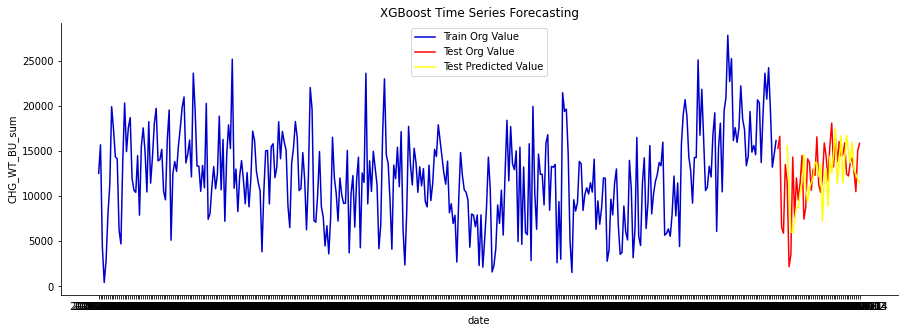

In [104]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x.SCH_DEP_DATE, x.CHG_WT_BU_sum, data=x, ax=ax, 
label='Train Org Value', color='mediumblue')
sns.lineplot(y.SCH_DEP_DATE, y.CHG_WT_BU_sum, data=y, ax=ax, 
label='Test Org Value', color='Red')
sns.lineplot(predicteddf.date, predicteddf.pred_value, data=predicteddf, ax=ax, 
label='Test Predicted Value', color='Yellow')

ax.set(xlabel = "date",
ylabel = "CHG_WT_BU_sum",
title = f"XGBoost Time Series Forecasting")

ax.legend()

sns.despine()
plt.savefig(f'XGBoost_TimesSeries_forecast.png')